In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
import time

In [2]:
IMG_DIM = (112, 92)
NR_PIXELS = IMG_DIM[0] * IMG_DIM[1]
NR_PEOPLE = 40
NR_IMG_PER_TRAIN_PERSON = 8
NR_IMG_PER_TEST_PERSON = 2
NR_IMG_PER_PERSON = 10
K_EIG = 20

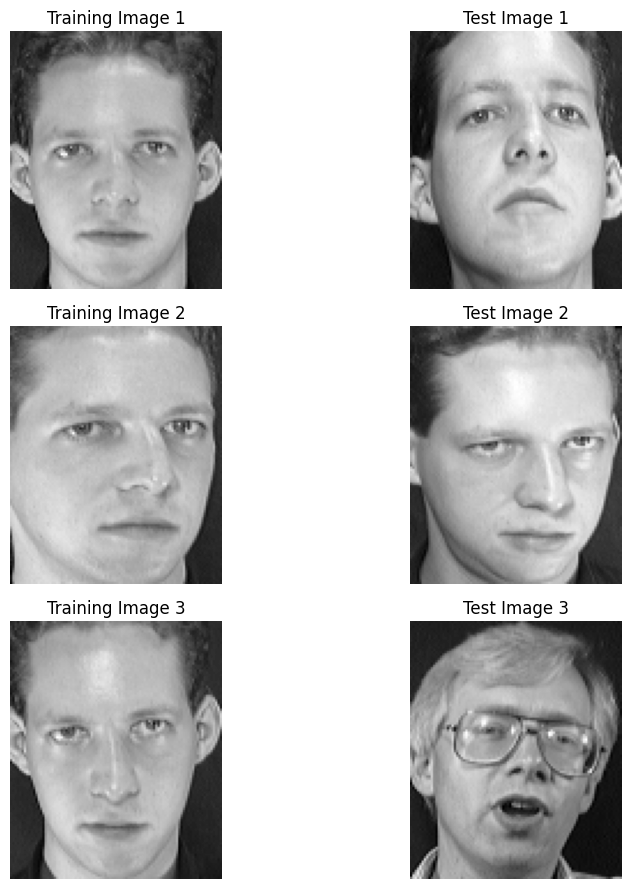

In [3]:
def split_dataset():
   A_train = np.empty((NR_PIXELS, 0))
   A_test = np.empty((NR_PIXELS, 0))
   
   for i in range(1, NR_PEOPLE+1):
       for j in range(1, NR_IMG_PER_TRAIN_PERSON+1):
           poza = cv2.imread(f'C:/Users/Administrator/Desktop/ASC/att_faces/s{i}/{j}.pgm', 0)
           poza = poza.flatten()[:, np.newaxis]
           A_train = np.hstack((A_train, poza))
           
       for j in range(NR_IMG_PER_TRAIN_PERSON+1, NR_IMG_PER_PERSON+1):
           poza = cv2.imread(f'C:/Users/Administrator/Desktop/ASC/att_faces/s{i}/{j}.pgm', 0)
           poza = poza.flatten()[:, np.newaxis]
           A_test = np.hstack((A_test, poza))
           
   return A_train, A_test

def plot_images_from_dataset(A_train, A_test, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
    
    for i in range(num_images):
        train_img = A_train[:, i] 
        ax1 = axes[i, 0]
        ax1.imshow(train_img.reshape(IMG_DIM), cmap='gray') 
        ax1.set_title(f'Training Image {i + 1}')
        ax1.axis('off')
        
        test_img = A_test[:, i]
        ax2 = axes[i, 1]
        ax2.imshow(test_img.reshape(IMG_DIM), cmap='gray')
        ax2.set_title(f'Test Image {i + 1}')
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

A_train, A_test = split_dataset()

plot_images_from_dataset(A_train, A_test, num_images=3)

PREPROCESARE

In [ ]:
'''
def get_lanczos_hqpb(A, k=K):
    m = A.shape[0]
    q = np.zeros((m, k + 2))
    q[:, 0] = np.zeros(m) 
    q[:, 1] = np.ones(m) 
    q[:, 1] /= np.linalg.norm(q[:, 1])
    beta = 0
    for i in range(1,k+1):
        w = (A @ (A.T @ q[:, i])) - beta * q[:, i-1]
        alpha = np.dot(w, q[:, i])
        w = w - alpha * q[:, i]
        beta = beta = np.linalg.norm(w)
        q[:, i+1] = w / beta
    return q[:, 2:k+2]
'''

In [5]:
def get_lanczos_hqpb(A, k=K_EIG):
    m = A.shape[0]
    q = np.zeros((m, k + 2))
    
    # Initialize q[:, 1] with a random normalized vector
    #q[:, 1] = np.random.rand(m)
    q[:, 1] = np.ones(m)
    q[:, 1] /= np.linalg.norm(q[:, 1])
    
    beta = 0
    for i in range(1, k + 1):
        # Compute new Lanczos vector
        w = (A @ (A.T @ q[:, i])) - beta * q[:, i-1]
        
        # Orthogonalize against the current basis
        for j in range(1, i + 1):
            w -= np.dot(w, q[:, j]) * q[:, j]
        
        # Normalize to create the next basis vector
        beta = np.linalg.norm(w)
        if beta == 0:
            break
        q[:, i+1] = w / beta
    
    return q[:, 2:k+2]  # Return the orthonormal basis

In [6]:
def preprocess(A, K_EIG=K_EIG):
    avg_face = np.mean(A, axis=1)
    HQPB = get_lanczos_hqpb(A, k=K_EIG)
    proj_faces = np.dot(HQPB.T, A)
    return HQPB, proj_faces, avg_face

In [7]:
HQPB_train, proj_faces_train , avg_face = preprocess(A_train)

(10304, 20) (20, 320) (10304,)


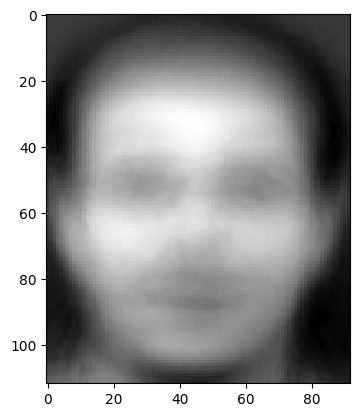

In [8]:
print(HQPB_train.shape, proj_faces_train.shape, avg_face.shape)
plt.imshow(avg_face.reshape(IMG_DIM), cmap='gray')

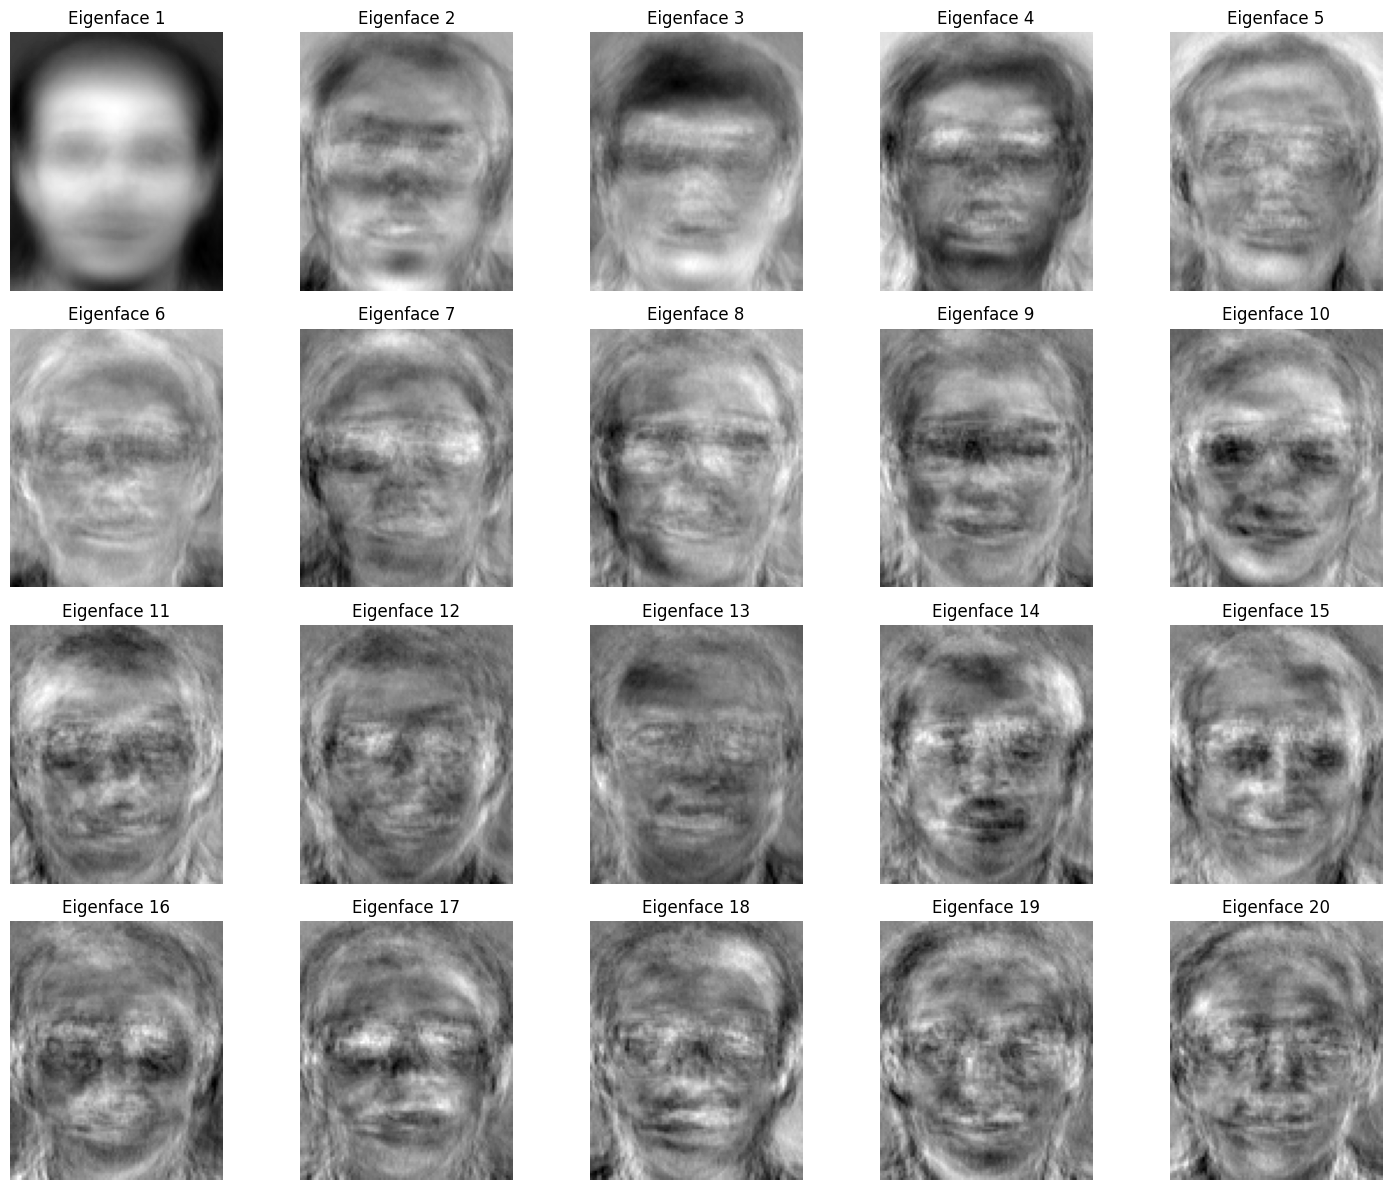

In [9]:
def plot_eigenfaces(eigenfaces, num_eigenfaces=20, cols=5):
    rows = (num_eigenfaces + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()
    
    for i in range(num_eigenfaces):
        eigenface = eigenfaces[:, i]
        ax = axes[i]
        ax.imshow(eigenface.reshape(IMG_DIM), cmap='gray')
        ax.set_title(f'Eigenface {i + 1}')
        ax.axis('off')
    
    for i in range(num_eigenfaces, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_eigenfaces(HQPB_train, num_eigenfaces=K_EIG)

INTEROGARE (KNN PROIECTII)

In [10]:
def norma_1(x):
    return np.linalg.norm(x, 1)

def norma_2(x):
    return np.linalg.norm(x, 2)

def norma_inf(x):
    return np.linalg.norm(x, np.inf)

def cosine_norm(x, y):
    return 1 - np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

norms = {
    '1': norma_1,
    '2': norma_2,
    'inf': norma_inf,
    'cosine': cosine_norm
}

In [11]:
def query_image(image, A, norma, k):
    image = image - avg_face
    proj_image = np.dot(HQPB_train.T, image)
    predicted_person, predicted_image_idx = KNN(proj_image, A, norma, k)
    return predicted_person, predicted_image_idx

def KNN(image, A, norma, k=3):
    distances = []
    
    for i in range(A.shape[1]):
        image_A = A[:, i]
        
        if norma == cosine_norm:
            distance = norma(image, image_A)
        else:
            distance = norma(image - image_A)
        
        distances.append((distance, i))
    
    distances.sort(key=lambda x: x[0])
    k_nearest_neighbors = distances[:k]
    
    person_ids = [neighbor[1] // NR_IMG_PER_TRAIN_PERSON for neighbor in k_nearest_neighbors]

    predicted_person = Counter(person_ids).most_common(1)[0][0]
    predicted_image_idx = k_nearest_neighbors[person_ids.index(predicted_person)][1]
    
    return predicted_person, predicted_image_idx

In [12]:
def calculate_accuracy_knn(A_test, norms, k=3, norm_type='2'):
    correct_predictions = 0
    total_tests = A_test.shape[1] 
    total_query_time = 0
    
    selected_norm = norms[norm_type]
    
    for test_idx in range(total_tests):
        actual_person = test_idx // NR_IMG_PER_TEST_PERSON
        test_image = A_test[:, test_idx]  

        start_time = time.time()
        predicted_person, predicted_image_idx = query_image(test_image, proj_faces_train, norma=selected_norm, k=k)
        end_time = time.time()

        query_time = end_time - start_time
        total_query_time += query_time
        
        if predicted_person == actual_person:
            correct_predictions += 1
    
    accuracy = (correct_predictions / total_tests) * 100
    avg_query_time = total_query_time / total_tests

    return accuracy, avg_query_time

In [13]:
norm_choice = input("Enter the norm you want to use ('1', '2', 'inf', 'cosine'): ")

if norm_choice not in norms:
    print("Invalid norm choice! Please choose from '1', '2', 'inf', or 'cosine'.")
else:
    k_choice = input("Enter the value of k for KNN (e.g., 1, 3, 5, 7): ")
    
    try:
        k = int(k_choice)
        if k <= 0:
            raise ValueError("k must be a positive integer.")
    except ValueError as e:
        print(f"Invalid k value! {e}")
    else:
        accuracy, avg_query_time = calculate_accuracy_knn(A_test, norms, k=k, norm_type=norm_choice)  
        print(f"Accuracy of K-th Nearest Neighbor classifier with k={k} and {norm_choice} norm: {accuracy:.2f}%")

Accuracy of K-th Nearest Neighbor classifier with k=3 and 2 norm: 42.50%


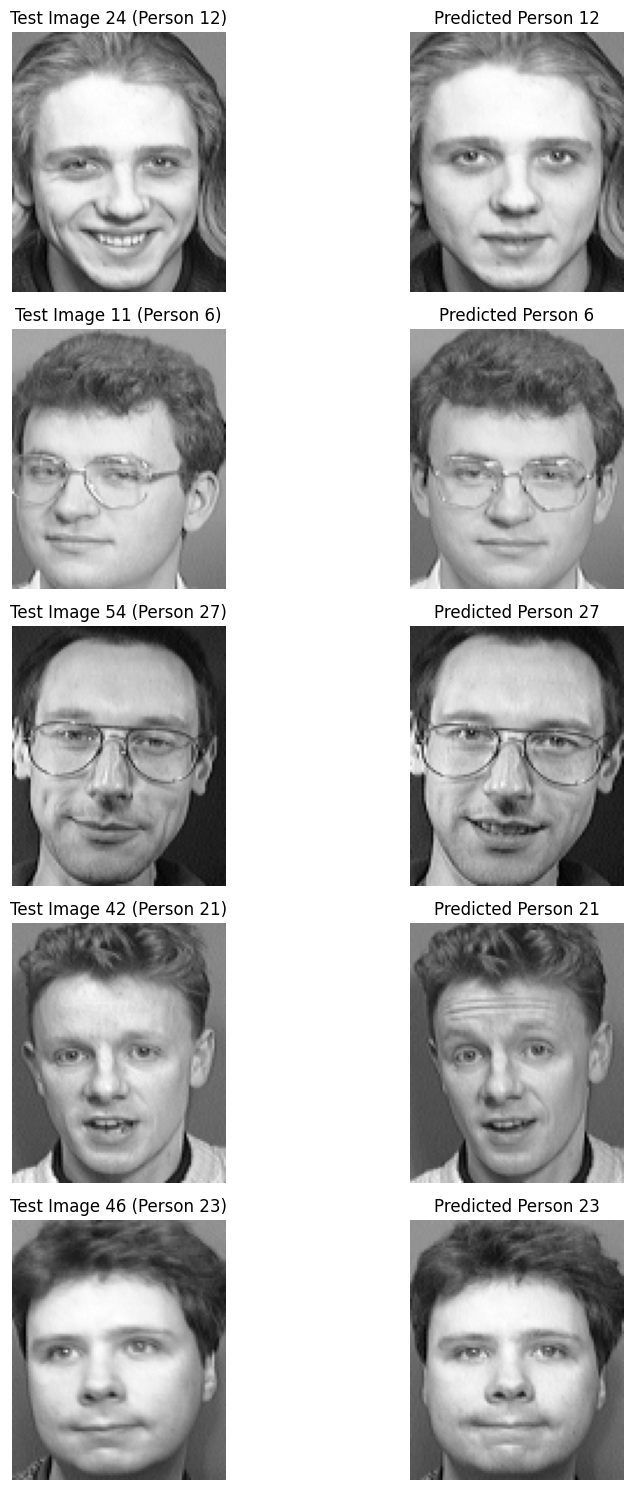

Accuracy for 5 test images using 1 norm with k=1: 100.00%


In [14]:
def test_predictions(A_train, A_test, norms, norm_type='2', k=1, num_images=5):
    correct_predictions = 0
    test_indices = random.sample(range(A_test.shape[1]), num_images) 
    
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
    
    for i, test_idx in enumerate(test_indices):
        actual_person = test_idx // NR_IMG_PER_TEST_PERSON
        
        test_image = A_test[:, test_idx]  

        predicted_person, predicted_image_idx = query_image(test_image, proj_faces_train, norma=norms[norm_type], k=k) 
        predicted_image = A_train[:, predicted_image_idx] 

        ax1, ax2 = axes[i]
        ax1.imshow(test_image.reshape(112, 92), cmap='gray')
        ax1.set_title(f'Test Image {test_idx + 1} (Person {actual_person + 1})')
        ax1.axis('off')
        
        ax2.imshow(predicted_image.reshape(112, 92), cmap='gray') 
        ax2.set_title(f'Predicted Person {predicted_person + 1}')
        ax2.axis('off')
        
        if predicted_person == actual_person:
            correct_predictions += 1
    
    plt.tight_layout()
    plt.show()
    
    accuracy = correct_predictions / num_images * 100
    print(f"Accuracy for {num_images} test images using {norm_type} norm with k={k}: {accuracy:.2f}%")
    
k_choice = 1 
test_predictions(A_train, A_test, norms, norm_type='1', k=k_choice, num_images=5)

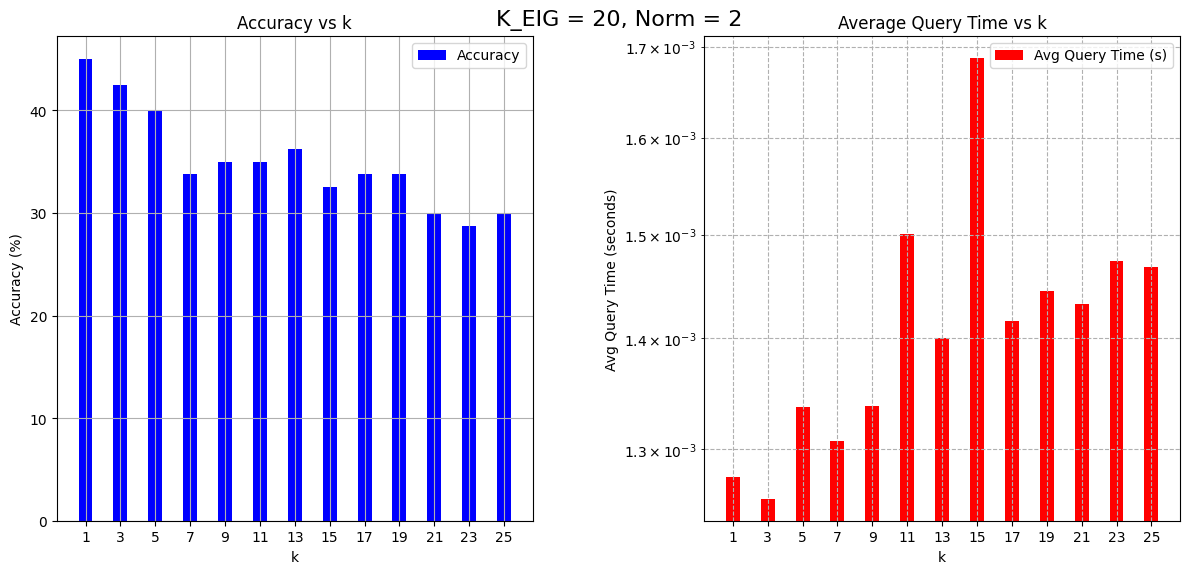

In [15]:
def plot_accuracy_and_query_time(A_test, norms, norm_type='2', k_values=[1, 3, 5]):
    accuracies = []
    avg_query_times = []

    for k in k_values:
        accuracy, avg_query_time = calculate_accuracy_knn(A_test, norms, k=k, norm_type=norm_type)
        accuracies.append(accuracy)
        avg_query_times.append(avg_query_time)

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(k_values, accuracies, color='b', label='Accuracy')
    plt.title('Accuracy vs k')
    plt.xlabel('k')
    plt.ylabel('Accuracy (%)')
    plt.xticks(k_values) 
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.bar(k_values, avg_query_times, color='r', label='Avg Query Time (s)')
    plt.title('Average Query Time vs k')
    plt.xlabel('k')
    plt.ylabel('Avg Query Time (seconds)')
    plt.xticks(k_values) 
    plt.yscale('log') 
    plt.grid(True, which="both", ls="--")
    plt.legend()

    plt.text(0.52, 0.95, f'K_EIG = {K_EIG}, Norm = {norm_type}', fontsize=16, ha='center', va='top', transform=plt.gcf().transFigure)

    plt.tight_layout()
    plt.show()

k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
plot_accuracy_and_query_time(A_test, norms, norm_type='2', k_values=k_values)


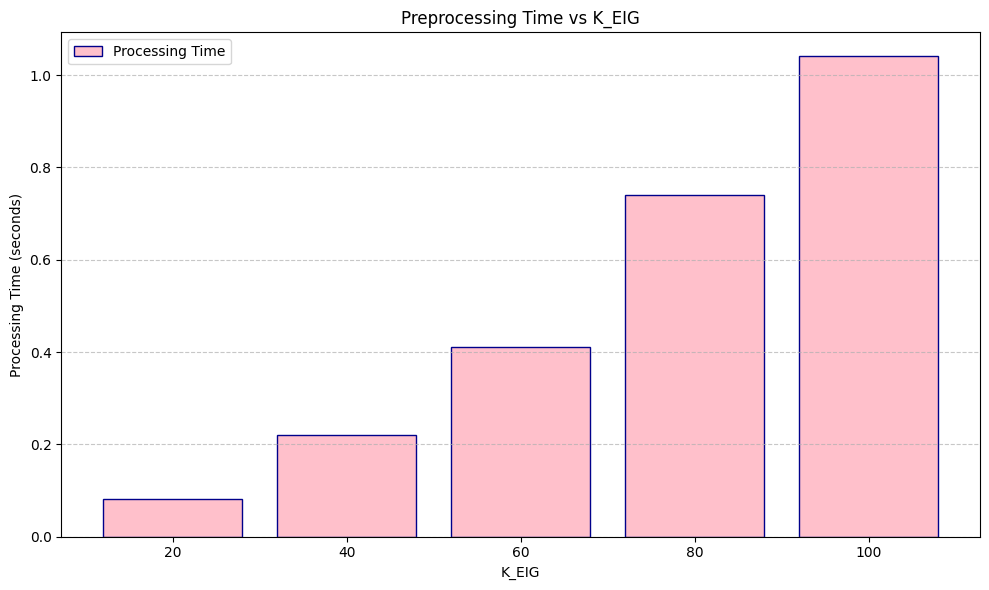

In [16]:
import time
import matplotlib.pyplot as plt

def measure_preprocess_time(A, K_EIG_values):
    times = []

    for K_EIG in K_EIG_values:
        start_time = time.time() 
        _, _, _ = preprocess(A, K_EIG)
        end_time = time.time() 

        elapsed_time = end_time - start_time
        times.append(elapsed_time)

    return times

def plot_preprocess_time(A, K_EIG_values):
    times = measure_preprocess_time(A, K_EIG_values)
    K_EIG_labels = [str(k) for k in K_EIG_values]

    plt.figure(figsize=(10, 6))

    bar_width = 0.8
    plt.bar(K_EIG_labels, times, width=bar_width, color='pink', edgecolor='darkblue', label='Processing Time', align='center')

    plt.title('Preprocessing Time vs K_EIG')
    plt.xlabel('K_EIG')
    plt.ylabel('Processing Time (seconds)')

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()

    plt.show()

K_EIG_values = [20, 40, 60, 80, 100]
plot_preprocess_time(A_train, K_EIG_values)

NOTE: Here we get best K_EIG eigenvectors iteratively, so the complexity of the preprocessing depends more on the K_EIG (O(m^2*k) to find the eigenvectors compared to O(m^3))